In [1]:
import requests
import zipfile
import pandas as pd
import os
from io import BytesIO
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature
import optuna
from optuna.samplers import TPESampler


C:\Users\PC\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
cd extracted_data/

C:\Users\PC\Documents\Proyect\extracted_data


In [29]:
df = pd.read_csv("line_c_w_counts.csv")
df['fecha_de_inicio'] = pd.to_datetime(df['fecha_de_inicio'])
df.set_index('fecha_de_inicio', inplace=True)
df.head(10)

,station,total_pax
fecha_de_inicio,,
2024-01-01 08:00:00,Constitucion,375.0
2024-01-01 09:00:00,Constitucion,366.0
2024-01-01 10:00:00,Constitucion,527.0
2024-01-01 11:00:00,Constitucion,414.0
2024-01-01 12:00:00,Constitucion,768.0
2024-01-01 13:00:00,Constitucion,661.0
2024-01-01 14:00:00,Constitucion,924.0
2024-01-01 15:00:00,Constitucion,625.0
2024-01-01 16:00:00,Constitucion,1239.0


In [30]:
# List of unique stations
stations = df['station'].unique()

# Create an empty DataFrame for all stations and time range
full_index = pd.MultiIndex.from_product([stations, pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')], names=['station', 'fecha_de_inicio'])
df_full = pd.DataFrame(index=full_index).reset_index()

# Merge with the original DataFrame to include actual data
df_full = df_full.merge(df.reset_index(), on=['station', 'fecha_de_inicio'], how='left')

# Fill missing values with zero
df_full['total_pax'] = df_full['total_pax'].fillna(0)

# Set the index back
df_full = df_full.set_index('fecha_de_inicio')
result_df = df_full
result_df

,station,total_pax
fecha_de_inicio,,
2024-01-01 08:00:00,Constitucion,375.0
2024-01-01 09:00:00,Constitucion,366.0
2024-01-01 10:00:00,Constitucion,527.0
2024-01-01 11:00:00,Constitucion,414.0
2024-01-01 12:00:00,Constitucion,768.0
...,...,...
2024-03-31 18:00:00,Diagonal Norte,123.0
2024-03-31 19:00:00,Diagonal Norte,63.0
2024-03-31 20:00:00,Diagonal Norte,78.0


In [31]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

#result_df = result_df[(result_df['station'] == 'Retiro')]

# Fit LabelEncoder and transform the 'estacion' column
result_df['station'] = label_encoder.fit_transform(result_df['station'])
# Convert 'fecha_de_inicio' to an integer format (e.g., Unix timestamp)
#X = result_df['station_le']
#y = result_df['total_pax']

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Extract time-based features from the index
#result_df['year'] = df.in.year
result_df['day_of_week'] = result_df.index.dayofweek
result_df['day'] = result_df.index.day
result_df['hour'] = result_df.index.hour
result_df['is_weekend'] = result_df.index.dayofweek >= 5
result_df['week_of_year'] = result_df.index.isocalendar().week

#result_df['month'] = result_df.index.month

# Initialize the scaler
#scaler = StandardScaler()

# Fit and transform the target variable
#result_df[TARGET] = scaler.fit_transform(result_df[[TARGET]])

#for lag in range(24*7, 24*7):  # Create lags from 1 to 11
result_df[f'total_pax_lag_{24*3}'] = result_df['total_pax'].shift(24*3)
#result_df[f'total_pax_lag_{24*7}'] = result_df['total_pax'].shift(24*7)
result_df['rolling_mean_3'] = result_df['total_pax'].rolling(window=3).mean()
result_df['rolling_std_3'] = result_df['total_pax'].rolling(window=3).std()
result_df['rolling_min_3'] = result_df['total_pax'].rolling(window=3).min()
result_df['rolling_max_3'] = result_df['total_pax'].rolling(window=3).max()
result_df['rolling_mean_6'] = result_df['total_pax'].rolling(window=6).mean()
result_df['rolling_mean_12'] = result_df['total_pax'].rolling(window=12).mean()
result_df['rolling_mean_18'] = result_df['total_pax'].rolling(window=18).mean()




result_df = result_df.dropna()

    
train = result_df.iloc[:-24*3,:]
test = result_df.iloc[-24*3:,:]
#X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]

TARGET = 'total_pax'
FEATURES = [col for col in result_df.columns if col != TARGET]



X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


X_train, y_train

(                     station  day_of_week  day  hour  is_weekend  \
 fecha_de_inicio                                                    
 2024-01-04 08:00:00        1            3    4     8       False   
 2024-01-04 09:00:00        1            3    4     9       False   
 2024-01-04 10:00:00        1            3    4    10       False   
 2024-01-04 11:00:00        1            3    4    11       False   
 2024-01-04 12:00:00        1            3    4    12       False   
 ...                      ...          ...  ...   ...         ...   
 2024-03-28 18:00:00        2            3   28    18       False   
 2024-03-28 19:00:00        2            3   28    19       False   
 2024-03-28 20:00:00        2            3   28    20       False   
 2024-03-28 21:00:00        2            3   28    21       False   
 2024-03-28 22:00:00        2            3   28    22       False   
 
                      week_of_year  total_pax_lag_72  rolling_mean_3  \
 fecha_de_inicio             

In [32]:
#create, train and do inference of the model
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
#calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2128
[LightGBM] [Info] Number of data points in the train set: 19431, number of used features: 14
[LightGBM] [Info] Start training from score 419.141578
Mean Absolute Error: 8.37247247380769


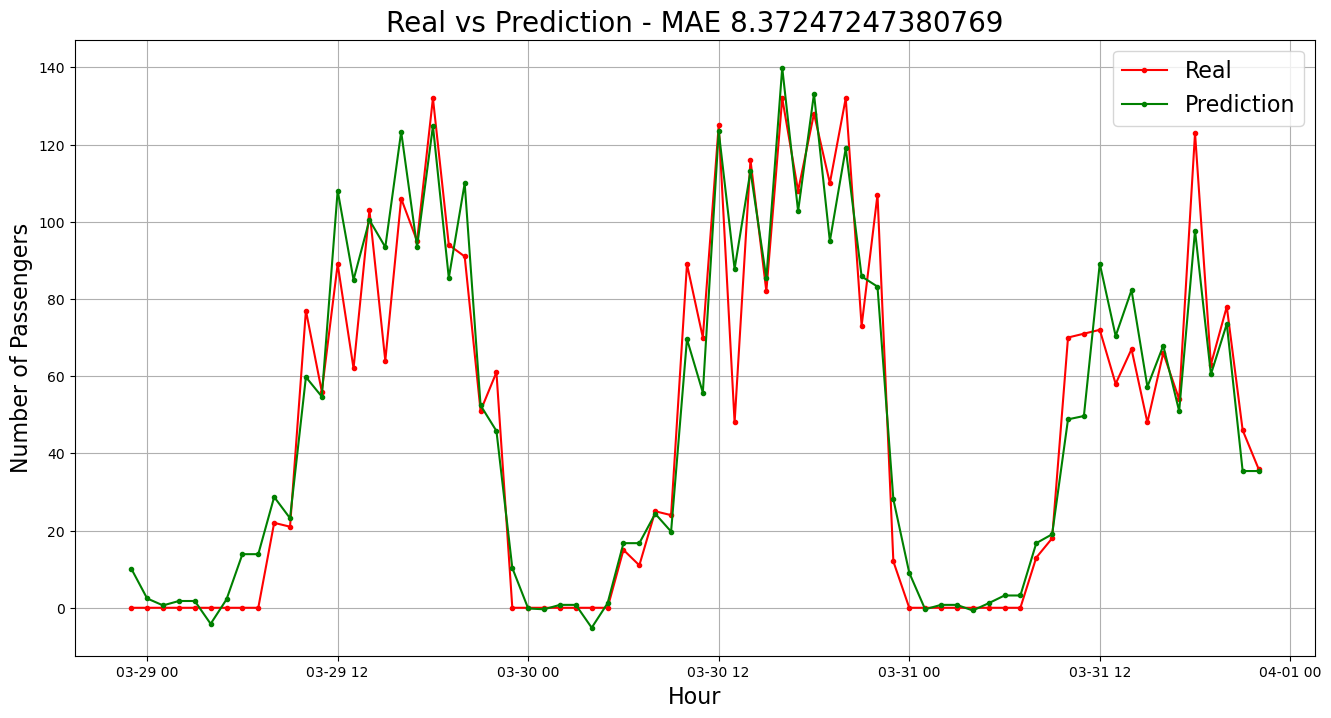

In [33]:
#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,8))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_test, color='red', marker='.')
plt.plot(pd.Series(y_pred, index=y_test.index), color='green', marker='.')
plt.xlabel('Hour', fontsize=16)
#plt.xlim(last_3_days, y_test.index[-1])
plt.ylabel('Number of Passengers', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()
